# Land Cover Classification for use in the CAPRA Model 

The CAPRA model for flood hazards is a secondary hazard model that requires spatially explicit runoff factors (Fig. 1, Tbl. 1).  Spatially explicit runoff values are determined from water evaporation and infiltration rates, which are a function of the land cover, land use and the soil characteristics of a location.  Hence, to produce a runoff factor (N) map it is essential to have a land cover map.

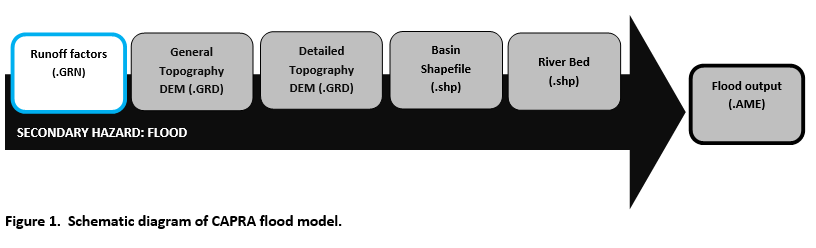

In [1]:
from IPython.display import Image
Image(filename='CAPRAflood.PNG')

The purpose of this tutorial is to derive a land cover map from satellite imagery using a classification method called recursive partitioning.  The procedure for the classification process is outlined in Figure 2. 

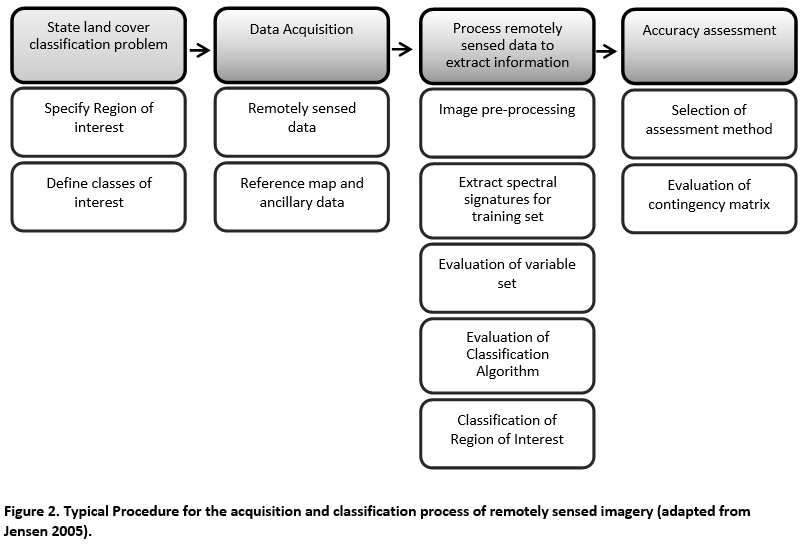

In [3]:
Image(filename='JensenClfProcess.PNG')

# Initial Setup.

In [4]:
import sys
print(sys.path)

['C:\\Users\\xmesa\\DRR', 'C:\\Users\\xmesa\\AppData\\Local\\Continuum\\anaconda3\\envs\\ee_py3\\python37.zip', 'C:\\Users\\xmesa\\AppData\\Local\\Continuum\\anaconda3\\envs\\ee_py3\\DLLs', 'C:\\Users\\xmesa\\AppData\\Local\\Continuum\\anaconda3\\envs\\ee_py3\\lib', 'C:\\Users\\xmesa\\AppData\\Local\\Continuum\\anaconda3\\envs\\ee_py3', '', 'C:\\Users\\xmesa\\AppData\\Local\\Continuum\\anaconda3\\envs\\ee_py3\\lib\\site-packages', 'C:\\Users\\xmesa\\AppData\\Local\\Continuum\\anaconda3\\envs\\ee_py3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\xmesa\\.ipython']


In [5]:
import bqplot
import datetime
import dateutil.parser
import ee
import ipywidgets
import IPython.display
import numpy as np
import pprint
import pandas as pd
import traitlets

# Configure the pretty printing output.
pp = pprint.PrettyPrinter(depth=4)

In [6]:
# Authenticate to the Earth Engine servers, and initialize the ee module.
ee.Initialize()

# Classification Scheme Definition

The classes and the detail of a classification scheme of a land cover map are determined by its intended use.  A classification scheme can have multiple levels of detail.  It is good practice to design a classification scheme with mutually exclusive and exhaustive classes of either land cover OR land use.  For different levels or scales the class details need to be determined in a way that they can be easily aggregated such as in a hierarchical structure.  

The classification scheme used in the runoff factor map delineation in the CAPRA flood model consists of a mixture of detailed land cover and land use classes as described in Table 1.  This is not an optimal scenario as overlap of classes can lead to non-exclusiveness of classes (e.g., impermeable surface and paved roads).  It is not consistent in the level of the hierarchical structure either.  The two level one forest land cover classes in the classification scheme are “natural forests” differentiated from “forests” which at the second level are further divided into  seeded or cultivated.  Further “cropped furrows”,” cereals”, “leguminous” and their subclasses can be grouped under agricultural or cropland at the first level. Roads, rangeland and rest (uncultivated) are pure land use classes, with class “rangeland” overlapping with class “pasture”.  

In general it is a lot more difficult to derive land use from a remotely sensed image than it is to detect land cover, as land cover describes the surface material and therefore has a direct linkage to the spectral reflectance behavior of the material (e.g. land cover grassland vs. land use classes pasture, football field, city park).  Land use classification of detailed agricultural classes as suggested by the CAPRA classification scheme requires a very good knowledge and expertise of a region’s agricultural practices.  

An important component of a land-cover classification procedure is the proper choice and delineation of training sites, used to train the computer in pattern recognition.  It is crucial to develop a database of reference points with reliable ground cover or use information at the spatial scale and thematic detailed at which the mapping procedure will be performed.  Preferably such reference points are acquired in the field (in situ) or from high resolution aerial photography.  For each of the different land cover types of interest a set of representative samples would be collected using a GPS (or digitizing technique).  

In our case we do not have a database of ground reference points or aerial photography, and we do not have an intimate knowledge of agricultural practices of the region, therefore we will refer to the U.S. Geological Survey Land Use/Land Cover Classification System for use with Remote Sensor Data (Tbl. 2).  

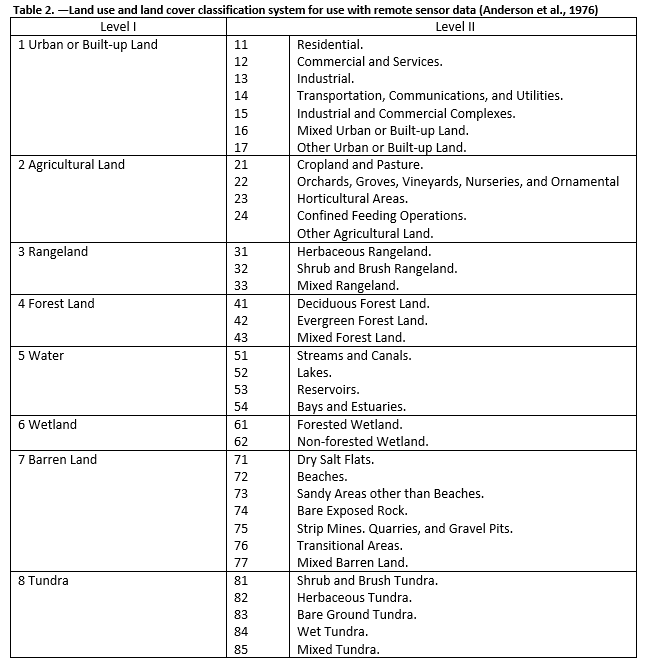

In [7]:
from IPython.display import Image
Image(filename='LCclassTable.PNG')

For this tutorial we will use classes based on level one of the USGS classification system.  The classes of interest for our mapping application are: Water, Forest Land, Rangeland, Agricultural Land, Barren Land, and Urban or Built-up Land.  
Since the classification scheme is a mix of land cover and land use we will rename classes with land use character to their corresponding land cover.  We also want to avoid spaces in the class names since we are going to use the names in code and spaces can be problematic.  The class names we are going to use instead are:

(1)	water 
(2)	forestLand
(3)	grassLand
(4)	cropLand
(5)	barrenLand
(6)	buildUpLand 

#### Question:
#### (1) Which of the level one classes of the U.S. Geological Survey Land Use/Land Cover Classification System for use with remote                  sensor Data do you expect to be present in your ROI (google it).

# Remote Sensing Process

One of the more common procedures to generate thematic land cover maps of a region is by applying pattern-recognition algorithms to satellite imagery in a digital image processing environment.  The use of remote sensing classification methods involve three general steps, (1) the selection and pre-processing of imagery adequate for the mapping of land cover classes of interest at their appropriate scales, (2) extraction and evaluation of spectral signatures and their statistical separability for all land cover classes of interest and development of a classification method and (3) evaluation and documentation of the mapping process and the final map product.   

(1)	Discrimination, and mapping of various land use/land cover classes depends on the spatial resolution (pixel size); the spectral resolution (number of bands or channels and their bandwidth); the radiometric resolution (range of discrete brightness values); and the temporal resolution (return time of the sensor) in relation to the classification scheme and minimum mapping unit or appropriate scale (Teillet et al., 1997 ,Rao et al., 2007).  Since the limitations of a mapping project are often constrained by its budget, the most economic approach to consider is to use date free of charge processed with open source image processing software, which is the a solution demonstrated in this tutorial.  

A large Landsat archive of 37 years of image acquisitions is available and open to the public. Landsat sensor specific information are accessible through the data portal of USGS (http://landsat.usgs.gov/Landsat_Search_and_Download.php).  For this exercise we are going to use two Landsat 5 images from November 4th, 2011.  We are not using a Landsat 7 ETM image because of the failure of the Scan Line Corrector (SLC) in April of 2003 resulting in imagery with significant geometric error and considerable areas of no data value in each -scene.  The Landsat 5 data source is adequate for the classes we identified in the classification scheme.  The digital image pre-processing including radiometric corrections will be performed in SAGA GIS.   

(2)	The extraction and evaluation of spectral signatures of all land cover classes of interest requires a training dataset.  In this exercise a set of training points for each class will be digitized on screen using the Google Earth application.  For the digitized sampling points spectral characteristics will then be extracted from the pre-processed imagery.  The variables we are interested in evaluating are reflectance values.  In addition we will consider derivative information, the Normalized Difference Vegetation Index (NDVI) a vegetation index and tasseled cap or Kauth-Thomas transformation which is based on the relationship of spectral characteristics to soil brightness, moisture content and vegetation cover.  The pre-processing and preparation of all data and the extraction of variable values for each sample of the training data set will be performed in SAGA GIS.  

The classification process is guided by the evaluation of the separability of classes for different combinations of reflectance bands and other derived variables based on the training set.  Separability analysis and feature selection are frequently based on descriptive class parameters such as the class specific mean vector and variance-covariance matrices.  For this tutorial instead of using parametric measures to evaluate class-separability, we will evaluate the effectiveness of a recursive partitioning algorithm, a non-parametric classification procedure (see pg. 38 in landCoverClassification_Theory.pdf).  Performance of different classifiers is assessed for all evaluated models based on accuracy measures derived from confusion matrices of the classified training dataset.  This initial evaluation of accuracies has a bias towards overestimating accuracies, and will only be used to select the model with the best fit.  The analysis will provide two important components for the final classification, a list of variables that are most suitable to differentiate the classes of interest, and the decision rules or classification tree (the model or classifier), that will be applied to all pixels of the entire area of interest, the Pardo River Basin.  This part of the analysis will be performed in R.  The final classified map will be generated from the classified point data in SAGA GIS.    

(3)	The final step of the mapping project is the accuracy assessment of the final classification results (the final map).  For this purpose we will use a stratified random sampling design (see pg. 45 in landCoverClassification_Theory.pdf) applied to the sampling frame of all classified image elements (pixels).  For lack of ground reference data we will use Google Earth (or Google maps) as reference source to determine classification accuracy.


# Data Acquisition and Processing Options

Insert text

### Exploration: GloVis

Landsat data is collected continuously along a near vertical path as the satellite moves from north to south. The data is randomly divided into nominal scenes with a spacing of approximately 160km. Landsat data is collected in accordance with the World Wide Reference System (WRS), which has catalogued the world's land mass into 57,784 scenes, each 183 km wide by 170 km long (Jensen, 2005). These divisions facilitate querying satellite imagery over any portion of the world by specifying a nominal scene center designated by ‘path’ and ‘row’ numbers (Rocchio, June, 2011). When looking for a scene of a certain area, it can be obtained by using the path and row. If the path and row are not known, then the coordinates of the area of interest can be used. 

Several sites can be used to locate and obtain Landsat satellite imagery. Some recommended sites are  Global Visualization Viewer (GloVis) portal and Earth Explorer by USGS, these two are considered to have the most complete collection of Landsat data, spanning the entire time of the program, beginning in the early 1970’s. 

The USGS GloVis site at [blue_text](http://glovis.usgs.gov) distributes Landsat data, as well as some other imagery from ASTER, MODIS and some others. 

#### Question
#### (1)	What are path and row for the images that cover your ROI?

### Download (USGS-EE, ESPA)

Insert text

### Cloud Processing (GEE)

Insert text

# Image Evaluation and Visualization, Image Data Exploration (Python GEE)

We're going to work with a Landsat 8 image collection which has been processed to surface reflectance values (i.e. the processing has attempted to remove the atmospheric effects). The **Image ID** value is *LANDSAT/LC08/C01/T1_SR*. 

This dataset is the atmospherically corrected surface reflectance from the Landsat 8 OLI/TIRS sensors. These images contain 5 visible and near-infrared (VNIR) bands and 2 short-wave infrared (SWIR) bands processed to orthorectified surface reflectance, and two thermal infrared (TIR) bands processed to orthorectified brightness temperature

These data have been atmospherically corrected using LaSRC and includes a cloud, shadow, water and snow mask produced using CFMASK, as well as a per-pixel saturation mask.

Strips of collected data are packaged into overlapping "scenes" covering approximately 170km x 183km using a standardized reference grid.

Maybe link to GloVis?

In [8]:
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

Let's count how many images are in this collection.

In [9]:
# Uncomment the following line to count the images in the collection.
print(l8sr.size().getInfo())

813805


To display a single image, we can filter the collection down to a single image, and can request a "thumbnail"  URL for the scene.

## Get the image's band names and store them in a variable.

In [10]:
sample_image = ee.Image(
    l8sr.filterDate('2018-11-01', '2018-12-30')
        .filterBounds(ee.Geometry.Point(-70.0522, 18.7490))
        .first()
)
band_names_original = sample_image.bandNames()
band_names_original.getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B10',
 'B11',
 'sr_aerosol',
 'pixel_qa',
 'radsat_qa']

## Rename the image bands, so they are easier to read.

In [11]:
l8_bands = ee.Dictionary({
    'B1': 'ultra_blue',
    'B2': 'blue',
    'B3': 'green',
    'B4': 'red',
    'B5': 'nir',
    'B6': 'swir_1',
    'B7': 'swir_2',
    'B8': 'pan',
    'B9': 'cirrus',
    'B10': 'tirs_1',
    'B11': 'tirs_2',
    'sr_aerosol': 'sr_aerosol', 
    'pixel_qa': 'pixel_qa',
    'radsat_qa': 'radsat_qa'
})
band_names_new = l8_bands.values(sample_image.bandNames())
l8sr = l8sr.select(band_names_original, band_names_new)

In [12]:
print(l8_bands)

ee.Dictionary({
  "type": "Dictionary",
  "value": {
    "B1": "ultra_blue",
    "B2": "blue",
    "B3": "green",
    "B4": "red",
    "B5": "nir",
    "B6": "swir_1",
    "B7": "swir_2",
    "B8": "pan",
    "B9": "cirrus",
    "B10": "tirs_1",
    "B11": "tirs_2",
    "sr_aerosol": "sr_aerosol",
    "pixel_qa": "pixel_qa",
    "radsat_qa": "radsat_qa"
  }
})


#### Questions:
   #### (8) What is the spectral information represented in band 4?  
   #### (9)	Looking at the histogram of the near infrared band and looking at the layer, what could each of the two modes represent in                     the image?


## Print out a sample image's metadata.

The metadata file provides information about the conditions when an image is acquired. It generally contains the date, time, corner coordinates, pixel size, sun angle, and other information that may be needed to analyze an image. 

In [13]:
sample_image = ee.Image(
    l8sr.filterDate('2018-11-01', '2018-12-30')
        .filterBounds(ee.Geometry.Point(-70.0522, 18.7490))
        .first()
)
pp.pprint(sample_image.getInfo())

{'bands': [{'crs': 'EPSG:32619',
            'crs_transform': [30.0, 0.0, 305085.0, 0.0, -30.0, 2193915.0],
            'data_type': {'max': 32767,
                          'min': -32768,
                          'precision': 'int',
                          'type': 'PixelType'},
            'dimensions': [7621, 7791],
            'id': 'ultra_blue'},
           {'crs': 'EPSG:32619',
            'crs_transform': [30.0, 0.0, 305085.0, 0.0, -30.0, 2193915.0],
            'data_type': {'max': 32767,
                          'min': -32768,
                          'precision': 'int',
                          'type': 'PixelType'},
            'dimensions': [7621, 7791],
            'id': 'blue'},
           {'crs': 'EPSG:32619',
            'crs_transform': [30.0, 0.0, 305085.0, 0.0, -30.0, 2193915.0],
            'data_type': {'max': 32767,
                          'min': -32768,
                          'precision': 'int',
                          'type': 'PixelType'},
           

#### Questions:
#### (1)	What are the spatial, spectral, radiometric and temporal characteristics of Landsat 5 Thematic Mapper (TM) satellite imagery?
#### (2)	At what time was the scene obtained?
#### (3)	How many columns and rows does the scene contain?
#### (4)	What are the minimum and maximum spectral radiances and pixel values for Band 1 and Band 7?
#### (5)	What was the sun elevation angle when the scene was obtained?


We can request a "thumbnail" URL for the scene.

In [14]:
thumbnail_url = sample_image.getThumbUrl({
    'bands': 'red,green,blue',
    'min': 0,
    'max': 3000,
    'region': sample_image.geometry().bounds().getInfo()
})
IPython.display.HTML('Thumbnail URL: <a href={0}>{0}</a>'.format(thumbnail_url))

The image can be displayed within the notebook, using the *IPython.display.Image()* method.

In [15]:
IPython.display.Image(url=thumbnail_url)

A nice image, but not very interactive.

# Interactive Mapping

The ipyleaflet package can be used to display interactive maps. Here is a basic example:

In [47]:
import ipyleaflet
map1 = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
dc = ipyleaflet.DrawControl()
map1.add_control(dc)
map1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [48]:
# Get information from the map's drawing control.
dc.last_draw

{'type': 'Feature', 'geometry': None}

To display an Earth Engine generated image on the interactive map, we can use ipyleaflet's TileLayer object. First we start by defining a function that can generate a tile layer URL from an Earth Engine image object.

In [41]:
def GetTileLayerUrl(ee_image_object):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
  return tile_url_template.format(**map_id)

In [42]:
# Style the image.
tile_url = GetTileLayerUrl(sample_image.visualize(min=0, max=3000, gamma=1.5, bands= ['red', 'green', 'blue']))
map1.add_layer(ipyleaflet.TileLayer(url=tile_url))

Lets redefine our sample, expanding the date range and getting rid of out geometry filters.

In [50]:
map2 = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
map2

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [51]:
def ReplaceOverlayLayers(map_object, ee_image_object):
    for lyr in map_object.layers[1:]:
        map_object.remove_layer(lyr)
    tile_url = GetTileLayerUrl(ee_image_object)
    map_object.add_layer(ipyleaflet.TileLayer(url=tile_url))
        
filtered = (
    l8sr.filterDate('2016-01-01', '2016-02-02')
         .median()
#         .mean()
#         .max()
#         .min()
#        .reduce(ee.Reducer.percentile([25])).rename(band_names_new)
        .visualize(min=0, max=3000, bands=['red', 'green', 'blue'])
)
ReplaceOverlayLayers(map2, filtered)

# Derivation of Additional Information from Pre-Processed Data

As solar irradiance varies with time and atmospheric conditions, and we did not perform an atmospheric correction, the use of indices is a more robust measure of light reflectance characteristics from a surface.  Indices combine data from two or more spectral bands to accentuate land formation features.  Several Vegetation Indices (VIs) have been derived for Landsat data (Jensen, 2005). These indices are intended to enhance the vegetation signal, while minimizing any background effects or noise.  VIs can be calculated from brightness values (BVs), radiance values (Lλ) and reflectance values (ρp).  If vegetation transformations or indices are going to be used in spectral extraction for land cover classification purposes it is recommended to use reflectance values.

All of the the VIs that can be calculated with SAGA’s modules just require two input raster layers (two images): one containing infrared band values and another one containing red band values. We will use the Grid Calculator to generate the Normalized Difference Vegetation Index (NDVI) and and the Kauth Thomas Tasseled Cap Transformation (TC). 


## Calculate a Spectral Index (NDVI)

The Normalized Difference Vegetation Index (NDVI) is a quick and accurate way of analyzing vegetation in an image.  This calculation takes advantage of the fact that vegetation is very absorbent in the red band and very reflective in the near-infrared (NIR).  Therefore, surfaces with large amounts of vegetation can be found by comparing the ratio of red and NIR bands.

The output of NDVI is a new grid layer.  Higher values (above zero) signify a larger difference between the red and near infrared radiation recorded by the sensor - a condition associated with highly photosynthetically-active vegetation. Low NDVI values (less than zero) mean there is little difference between the red and NIR signals.  This is an indicator for presence of little photosynthetic activity, or when there is just very low NIR light reflectance (i.e., water reflects very low NIR light).

In [46]:
IPython.display.Image(url='https://landsat.usgs.gov/sites/default/files/images/LandsatSpectralBands_20160801.jpg')

The normalized difference vegetation index ($NDVI$) is a band ratio that is related to the amount of green vegetation. 

\begin{equation*}
NDVI = \frac{NIR — RED}{NIR + RED} = \frac{Band5 — Band4}{Band5 + Band4}
\end{equation*}

where $NIR$ is the near infrared band and $RED$ is red band.

## Write a function to add an NDVI band to an image.

In [23]:
def AddBandNDVI(img):
    red = img.select('red')
    nir = img.select('nir')
    ndvi = (nir.subtract(red)).divide(nir.add(red)).rename('ndvi')
    return img.addBands(ndvi)

l8sr = l8sr.map(AddBandNDVI)

In [24]:
# Define a NDVI colormap.
sld_ndvi = '''
<RasterSymbolizer>\
  <ChannelSelection>\
    <GrayChannel>\
      <SourceChannelName>ndvi</SourceChannelName>\
    </GrayChannel>\
  </ChannelSelection>\
  <ColorMap>\
    <ColorMapEntry color="#000000" quantity="0.0" />\
    <ColorMapEntry color="#BFBD27" quantity="0.1" />\
    <ColorMapEntry color="#1EBFBE" quantity="0.3" />\
    <ColorMapEntry color="#29FD2F" quantity="0.5" />\
    <ColorMapEntry color="#1CBD20" quantity="0.7" />\
    <ColorMapEntry color="#0F7E12" quantity="0.9" />\
  </ColorMap>\
</RasterSymbolizer>
'''
ndvi_legend = ipywidgets.HTML('''
<form>
 <fieldset>
  <legend>NDVI:</legend>
  <pre style="text-align:center;background-color:#777777;color:white">0.0</pre>
  <pre style="text-align:center;background-color:#BFBD27">0.1</pre>
  <pre style="text-align:center;background-color:#1EBFBE">0.3</pre>
  <pre style="text-align:center;background-color:#29FD2F">0.5</pre>
  <pre style="text-align:center;background-color:#1CBD20">0.7</pre>
  <pre style="text-align:center;background-color:#0F7E12">0.9</pre>
 </fieldset>
</form>
''',
layout=ipywidgets.Layout(width='100px'))

In [25]:
map3 = ipyleaflet.Map(
    zoom=4,
    layout={'height':'400px', 'width': '800px'}
)
display(ipywidgets.HBox([map3, ndvi_legend]))

In [26]:
map3.add_layer(
    ipyleaflet.TileLayer(
        url=GetTileLayerUrl(
            l8sr.filterDate('2014-01-01', '2014-10-01')
                    .max()
                    .sldStyle(sld_ndvi)
        )
    )
)

# Time Series

In [27]:
def GetDataFrame(coords):
    
    pnt = ee.Geometry.Point(coords)
    # Sample for a time series of values at the point.
    geom_values = l8sr.filterBounds(pnt).select('ndvi').getRegion(geometry=pnt, scale=30)
    geom_values_list = ee.List(geom_values).getInfo()
    # Convert to a Pandas DataFrame.
    header = geom_values_list[0]
    data = pd.DataFrame(geom_values_list[1:], columns=header)
    data['datetime'] = pd.to_datetime(data['time'], unit='ms', utc=True)
    data.set_index('time')
    data = data.sort_values('datetime')
    data = data[['datetime', 'ndvi']]
    return data


In [28]:
# Plot scales.
lc1_x = bqplot.DateScale(min=datetime.date(2013, 2, 1), max=datetime.date(2018, 1, 1))
lc2_y = bqplot.LinearScale()

# Plot type (mark).
lc2 = bqplot.Lines(
    x=[],
    y=[],
    scales={'x': lc1_x, 'y': lc2_y}, 
    display_legend=True,
)

# Plot axes.
x_ax1 = bqplot.Axis(label='Date', scale=lc1_x, num_ticks = 6, tick_format='%Y-%b')
x_ay2 = bqplot.Axis(label='NDVI', scale=lc2_y, orientation='vertical')

# Declare the plot interactions.
br_intsel = bqplot.interacts.BrushIntervalSelector(scale=lc1_x, marks=[lc2])

# Create a figure.
fig = bqplot.Figure(
    marks=[lc2],
    axes=[x_ax1, x_ay2],
    layout={'height':'250px', 'width':'800px'},
    interaction=br_intsel
)

# Create a map widget with a drawing control.
map5 = ipyleaflet.Map(zoom=2, layout={'height':'270px', 'width':'800px'})
dc = ipyleaflet.DrawControl(polyline={}, polygon={})
map5.add_control(dc)

int_start_dp = ipywidgets.DatePicker(
    description='Start Date',
    disabled=True
)
int_end_dp = ipywidgets.DatePicker(
    description='End Date',
    disabled=True
)

# Create the event handlers for the map and plot.
def handle_draw(self, action, geo_json):
    # Get the selected coordinates from the map's drawing control.
    coords = geo_json['geometry']['coordinates']    
    new_df = GetDataFrame(coords)
    lc2.x = new_df['datetime']
    lc2.y = new_df['ndvi']
dc.on_draw(handle_draw)

def brush_selection_callback(change):
    (t1_start, t1_end) = change.new
    start_datetime = dateutil.parser.parse(t1_start)
    end_datetime = dateutil.parser.parse(t1_end)
    int_start_dp.value = start_datetime
    int_end_dp.value = end_datetime
    
    # Update the layer displayed on the map.
    filtered = (
        l8sr.filterDate(start_datetime.isoformat(), end_datetime.isoformat())
            .max()
            .sldStyle(sld_ndvi)
    )
    ReplaceOverlayLayers(map5, filtered)    
br_intsel.observe(brush_selection_callback, names=['selected'])

# Display the widgets.
space_time_viewer = ipywidgets.VBox(
    [
        ipywidgets.HBox([map5, ndvi_legend]),
        ipywidgets.HBox([
            fig, 
            #ipywidgets.VBox([
                #ipywidgets.HTML('Selected Dates:'),
                #int_start_dp,
                #int_end_dp
            #])
        ], layout=ipywidgets.Layout(align_content='center'))
    ],
    align_self='stretch'
)


In [29]:
space_time_viewer

# Kauth-Thomas Tasseled Cap Transformation

The Tasseled Cap Transformation is the conversion of the readings in a set of bands into composite values; i.e., the weighted sums of separate band readings. One of these weighted sums measures roughly the brightness of each pixel in the scene. The other composite values are linear combinations of the values of the separate channels, but some of the weights are negative and others positive. One of these other composite values represents the degree of greenness of the pixels and another might represent the degree of yellowness of vegetation or perhaps the wetness of the soil. Usually there are just three composite variables.

Tasseled cap indices give a measure of the brightness, greenness, or wetness of a pixel and utilize a linear combination of 6 of Landsat’s frequency bands. Each of the brightness, greenness, and wetness indices can be calculated using the expression:

tas.capi = (coeff1 * band1) + (coeff2 * band2) + (coeff3 * band3) + (coeff4 * band4) + (coeff5 * band5) + (coeff7 * band7) 

where tas.capi is the calculated tasseled cap index for brightness, greenness, or wetness depending on the coefficients used, the bands are the TOA reflectances calculated in this tutorial, and the coefficients are given by Huang et al. (2002):  

Index	Band 1	Band 2	Band 3	Band 4	Band 5	Band 7
Brightness	0.2909	0.2493	0.4806	0.5568	0.4438	0.1706
Greenness	-0.2728	-0.2174	-0.5508	0.7221	0.0733	-0.1648
Wetness	0.1446	0.1761	0.3322	0.3396	-0.6210	-0.4186


# Evaluation of Variable Set and Classification Algorithm

The usual approach to land cover classification of remotely sensed data requires a training dataset. In this exercise we will digitize training points for each land cover class in our classification scheme.  Spectral reflectance percentages and derivatives NDVI and TC will then be extracted for the training data set and exported to a format that can be used in R.  In R we will conduct the training set evaluation and variable selection and derive the decision rules using recursive partitioning methods.  This evaluation will provide us with the best model and variable set based, which will be applied to the catchment, our area of interest.

Steps:
(1)	Digitization of reference locations for training purposes (Google Earth)
(2)	Evaluation Routine for different variable sets (Python)


## Digitization of Reference Locations for Training Set (Google Earth)

We will now select the training point for each of our land cover classes using the high spatial resolution imagery of Google Earth.  First, the ‘Pardo River Basin’ vector layer needs to be converted to KML format to be able to import it into Google Earth so that it can be visualized. Since the study area of this classification exercise is the Pardo River Basin we will select our training points inside the boundaries of the basin.